In [48]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated, Literal
from langgraph.types import CachePolicy
from langgraph.cache.memory import InMemoryCache
from datetime import datetime

In [49]:
def reducer_func(old: list[str], new: list[str]):
    return old + new

In [50]:
import operator


class State(TypedDict):
    seed: int
    # time: str
    # messages: Annotated[list[str], reducer_func]
    # messages: Annotated[list[str], operator.add]


graph_builder = StateGraph(
    State,
)

In [51]:
def node_one(state: State):
    messages = state.get("messages", [])

    response = "Hello, nice to meet you"

    return {"messages": [response]}


def node_two(state: State):

    return {"time": f"{datetime.now()}"}


def node_three(state: State):

    return {}


def node_four(state: State):

    return {}

In [52]:
graph_builder.add_node("node_one", node_one)
graph_builder.add_node(
    "node_two",
    node_two,
    cache_policy=CachePolicy(
        ttl=20,  # Node will be cached for 20 secs / Use when node is expensive
    ),
)
graph_builder.add_node("node_three", node_three)
graph_builder.add_node("node_four", node_four)


# def route_func(state: State) -> Literal["node_three", "node_four"]:
#     if state["seed"] % 2 == 0:
#         return "node_three"
#     return "node_four"


def route_func(state: State):
    return state["seed"] % 2 == 0


graph_builder.add_conditional_edges(
    START,
    route_func,
    {
        True: "node_one",
        False: "node_two",
        "hello": END,
    },
)
graph_builder.add_edge("node_one", "node_two")
graph_builder.add_conditional_edges(
    "node_two",
    route_func,
    {
        True: "node_three",
        False: "node_four",
        "hello": END,
    },
)
graph_builder.add_edge("node_four", END)

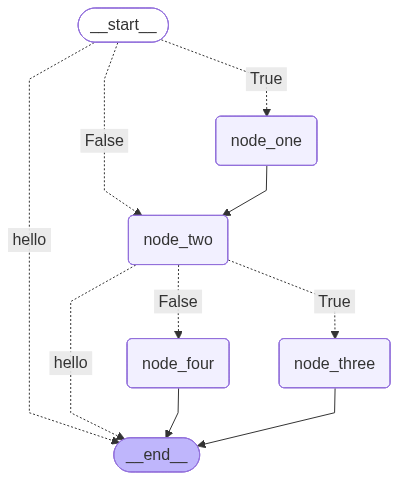

In [53]:
import time

graph = graph_builder.compile(cache=InMemoryCache())


# graph.invoke({"seed": 3})
graph